# Protein pretraining and property prediction

In this tuorial, we will go through how to build a simply sequence model for protein property prediction. In particular, we will demonstrate how to pretrain it and how to finetune it in the downstream tasks. More details of this topic can be found [here](https://github.com/PaddlePaddle/PaddleHelix/tree/dev/apps/pretrained_protein/tape).

In recent years, with sequencing technology development, the protein sequence database scale has significantly increased. However, the cost of obtaining labeled protein sequences is still very high, as it requires biological experiments. Besides, due to the inadequate number of labeled samples, the model has a high probability of overfitting the data. Borrowing the ideas from natural language processing (NLP), we can pre-train numerous unlabeled sequences by self-supervised learning. In this way, we can extract useful biological information from proteins and transfer them to other tagged tasks to make these tasks training faster and more stable convergence. These instructions refer to the work of paper TAPE, providing the model implementation of Transformer, LSTM, and ResNet.

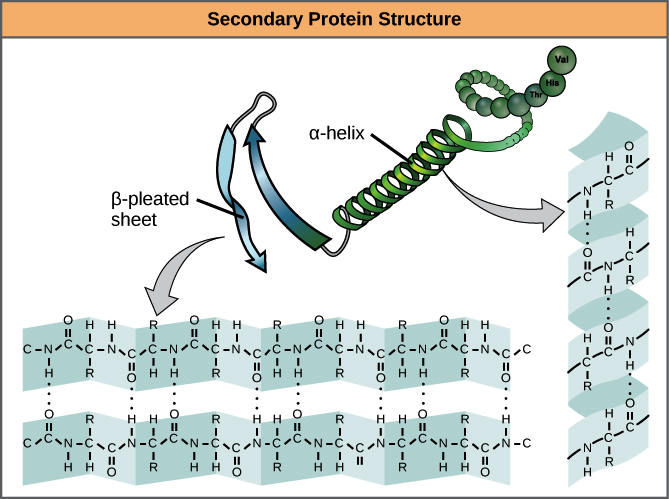

# Part I: Pretraining / Training

In [3]:
import os
import sys
os.chdir('../apps/pretrained_protein/tape')
sys.path.append('../../../')
sys.path.append('./')
os.environ["CUDA_VISIBLE_DEVICES"]="5"

/home/bio/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Model Configuration Settings

The network is setup according to `model_config`.
- Task-related configurations
    - "task": The type of training task. Candidate task types:
        - "pretrain": Leverage self-supervised learning for pretraining task，for dataset `TAPE`.
        - "classification": Clasification task, for dataset `Remote Homology`.
        - "regression": Regression task, for datasets `Fluroscence` and `Stability`.
        - "seq_classification": Sequence classification task, for dataset `Secondary Structure`.
    - "class_num": The number of class for tasks `classification` and `seq_classification`.
    - "label_name": The label name in the dataset.
- Network-related configurations
    - "model_type": The network type. For each network, we need to set the corresponding network hyper-parameters. We support the following networks:
        - "transformer"
            - ”hidden_size"
            - "layer_num"
            - "head_num"
        - "lstm"
            - "hidden_size"
            - "layer_num"
        - "resnet"
            - "hidden_size"
            - "layer_num"
            - "filter_size"
- Other configurations (See the code for more details)
    - "dropout_rate"
    - "weight_decay"
    
Following is the demo `model_config` of the task of `secondary_structure`.

In [4]:
model_config = \
{
    "model_name": "secondary_structure",

    "task": "seq_classification",
    "class_num": 3,
    "label_name": "labels3",

    "model_type": "lstm",
    "hidden_size": 512,
    "layer_num": 3,

    "comment": "The following hyper-parameters are optional.",
    "dropout_rate": 0.1,
    "weight_decay": 0.01
}

## Define the model

In [5]:
import paddle
from pahelix.model_zoo.protein_sequence_model import ProteinEncoderModel, ProteinModel, ProteinCriterion
from pahelix.utils.protein_tools import ProteinTokenizer

from data_gen import create_dataloader
from metrics import get_metric

train_data = './secondary_structure_toy_data'
model_dir = "./model"
paddle.set_device("gpu")

train_loader = create_dataloader(
    data_dir=train_data,
    model_config=model_config)

encoder_model = ProteinEncoderModel(model_config, name='protein')
model = ProteinModel(encoder_model, model_config)

# Generate parameter names needed to perform weight decay.
# All bias and LayerNorm parameters are excluded.
decay_params = [
    p.name for n, p in model.named_parameters()
    if not any(nd in n for nd in ["bias", "norm"])
]

grad_clip = paddle.nn.ClipGradByGlobalNorm(clip_norm=1.0)
optimizer = paddle.optimizer.AdamW(
    learning_rate=1e-4,
    epsilon=1e-06,
    weight_decay=0.01,
    grad_clip=grad_clip,
    parameters=model.parameters(),
    apply_decay_param_fun=lambda x: x in decay_params)

criterion = ProteinCriterion(model_config)
metric = get_metric(model_config['task'])


2021-05-11 14:55:10,464 - INFO - ujson not install, fail back to use json instead
2021-05-11 14:55:10,530 - INFO - Enabling RDKit 2021.03.1 jupyter extensions


## Train the model

In [6]:
train_sum_loss = 0
cur_step = 0
for epoch_id in range(2):
    model.train()
    for (text, pos, label) in train_loader:
        # print("text: ", text)
        cur_step += 1
        pred = model(text, pos)
        label = label.reshape([-1, 1])
        pred = pred.reshape([-1, pred.shape[-1]])
        loss = criterion.cal_loss(pred, label)

        print("loss: ", loss)
        train_sum_loss += loss.numpy()
        loss.backward()
        optimizer.minimize(loss)
        model.clear_gradients()

        pred = pred.numpy()
        label = label.numpy()
        loss = loss.numpy()
        metric.update(pred, label, loss)
        if cur_step % 10 == 0:
            print('step %d, avg loss %.5f' % (cur_step, train_sum_loss / 10))
            metric.show()
            train_sum_loss = 0
            metric.clear()
    print("saving model...")
    paddle.save(model.state_dict(), 'models/epoch_%s.pdparams' % epoch_id)


/home/bio/.local/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [1.10733032])
loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [1.09024048])
loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [1.06779253])
loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [1.07558334])
loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [1.06712484])
loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [1.06779575])
loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [1.05681002])
loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [1.05486381])
saving model...
loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_gradient=False,
       [1.06808329])
loss:  Tensor(shape=[1], dtype=float32, place=CUDAPlace(0), stop_g

# Part II: Inference

In this part, we will briefly introduce how to use the trained model to do inference on the given amino acid sequences.

In [7]:
import os
import time
import sys

import argparse
import json
import codecs
import numpy as np
import random
import paddle
import paddle.nn.functional as F
from pahelix.model_zoo.protein_sequence_model import ProteinEncoderModel, ProteinModel, ProteinCriterion
from pahelix.utils.protein_tools import ProteinTokenizer

from data_gen import create_dataloader, pad_to_max_seq_len
from metrics import get_metric
from paddle.distributed import fleet

predict_model = "./models/epoch_0.pdparams"
paddle.set_device("gpu")

encoder_model = ProteinEncoderModel(model_config, name='protein')
model = ProteinModel(encoder_model, model_config)
model.load_dict(paddle.load(predict_model))

tokenizer = ProteinTokenizer()
examples = [
    'MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR',
    'KQHTSRGYLHEFDGDPANRCHQSLYKWHDKDCDWLVDWEMKPMDALMETDHQPSMLVHLEQSYKWFCCIKGKPLNFAALLDGWTKITPMAKALYWRDHISEAWLIQCMFEEKILIVRTLMDENGTHKNYFVMSRLCGSCITFEWDSWEAEKPHKVWMGMKNCVSWKRKDVIEMVFERTQWAKWADNIYNWACCPMQVPEIIPFQFFYQTDENFCFKLLMKPCKFYYFSCHHLGHLHCLLKYQWYKGVYLGMRLRVFHKMIVCFHGHWTWVEGNSGIEGRGGIMMHTGITMDCFFDRNIQQSYGGSRWSEQNMKHSQHSRCDPYRTCEPEGTTPEQKCVQRQRIKVRVCHMPEDCLWTSCV',
]

example_ids = [tokenizer.gen_token_ids(example) for example in examples]
max_seq_len = max([len(example_id) for example_id in example_ids]) 
pos = [list(range(1, len(example_id) + 1)) for example_id in example_ids]
pad_to_max_seq_len(example_ids, max_seq_len)
pad_to_max_seq_len(pos, max_seq_len)

texts = paddle.to_tensor(example_ids)
pos = paddle.to_tensor(pos)
pred = model(texts, pos)
pred = pred.numpy()
print(pred)


/home/bio/anaconda3/envs/paddle_2.0/lib/python3.7/site-packages/paddle/tensor/creation.py:143: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


[[[ 0.06761645 -0.19984713  0.182233  ]
  [ 0.06345616 -0.31261012  0.28321555]
  [ 0.08944731 -0.37718743  0.3571944 ]
  ...
  [ 0.08170012 -0.31020513  0.33780777]
  [ 0.0524595  -0.24924025  0.2675811 ]
  [ 0.00963181 -0.09618369  0.1547178 ]]

 [[ 0.07289896 -0.20864804  0.1910027 ]
  [ 0.07133582 -0.3148525   0.28850096]
  [ 0.08563419 -0.37883243  0.34481043]
  ...
  [ 0.08957551 -0.298909    0.34127787]
  [ 0.05934989 -0.25140306  0.27160397]
  [ 0.01694548 -0.10635196  0.15368286]]]
